# LeNet5 Implementation from Scratch

In [1]:
#import package
import numpy as np 
import sys
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import time

In [2]:
from utils.LayerObjects import *
from utils.utils_func import *

In [3]:
import os
Task_name = 'Assignment1&2 dataset'
data_root = "/home/p88101029/"
raw_data_base = os.path.join(data_root,Task_name)
os.makedirs(raw_data_base, exist_ok=True)
listoffolder=sorted(os.listdir(raw_data_base), reverse=False)
import cv2
import numpy as np
from numpy import asarray
images = []
imagescat = []
imagesnames = []
for folder in listoffolder:
    images_path = os.path.join(raw_data_base,folder)
    address = sorted(os.listdir(images_path))
    for imgadd in address:
        imagescat.append(folder)
        imagesnames.append(imgadd)
        img=cv2.imread(os.path.join(images_path,imgadd))
        images.append(asarray(img))

In [4]:
imgs=[]
for i in images:
    img=cv2.resize(i,(64,64))
    imgs.append(img)

In [5]:
imagesarr=np.asarray(imgs)
imagescatarr=np.asarray(imagescat)

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(imagescatarr)
encoded_imagescatarr = encoder.transform(imagescatarr)
imagescatarr = np_utils.to_categorical(encoded_imagescatarr)

In [7]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
X_trainvalid, X_test, y_trainvalid, y_test = train_test_split(imagesarr,imagescatarr, test_size=0.1, random_state=0)

split_indext = np.concatenate((np.ones(round(len(y_trainvalid)*0.8)), np.zeros(round(len(y_trainvalid)*0.2))), axis=None).astype(bool)
split_indexv = np.concatenate((np.zeros(round(len(y_trainvalid)*0.8)), np.ones(round(len(y_trainvalid)*0.2))), axis=None).astype(bool)

train_image, train_label = X_trainvalid[split_indext], y_trainvalid[split_indext]
valid_image, valid_label = X_trainvalid[split_indexv], y_trainvalid[split_indexv]
test_image, test_label = X_test, y_test

train_image=np.moveaxis(train_image,3,1)
valid_image=np.moveaxis(valid_image,3,1)
test_image=np.moveaxis(test_image,3,1)

train_image=torch.from_numpy(train_image)
valid_image=torch.from_numpy(valid_image)
test_image=torch.from_numpy(test_image)
train_label=torch.from_numpy(train_label)
valid_label=torch.from_numpy(valid_label)
test_label=torch.from_numpy(test_label)

n_m, n_m_valid, n_m_test = len(train_label),len(valid_label), len(test_label)
print("The shape of training image:", train_image.shape)
print("The shape of validing image:", valid_image.shape)
print("The shape of testing image: ", test_image.shape)
print("Length of the training set: ", n_m)
print("Length of the validing set:", n_m_valid)
print("Length of the testing set: ", n_m_test)
print("Shape of a single image: ", train_image[0].shape)

The shape of training image: torch.Size([46242, 3, 64, 64])
The shape of validing image: torch.Size([11560, 3, 64, 64])
The shape of testing image:  torch.Size([6423, 3, 64, 64])
Length of the training set:  46242
Length of the validing set: 11560
Length of the testing set:  6423
Shape of a single image:  torch.Size([3, 64, 64])


In [8]:
def normalize(image):
    image = image.to(torch.float32)/256
    return image
train_image = normalize(train_image)
valid_image = normalize(valid_image)
test_image  = normalize(test_image)

In [9]:
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable

class LeNet5(nn.Module):

    # network structure
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding=0)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)
        self.fc1   = nn.Linear(120, 84)
        self.fc2   = nn.Linear(84, 50)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = F.max_pool2d(x, (4, 4))
        x = torch.tanh(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        x = torch.tanh(self.conv3(x))
        x = x[:,:,0,0]
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x


In [11]:
Net = LeNet5()
device = torch.device('cuda')
Net.to(device)
train_image=train_image.to(device)
valid_image=valid_image.to(device)
test_image=test_image.to(device)
train_label=train_label.to(device)
valid_label=valid_label.to(device)
test_label=test_label.to(device)

In [12]:
epoches = 100
learning_rate = 0.001
weight_decay = 0
batch_size = 256

In [17]:
#Training loops

acc_rate_list = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr=learning_rate,weight_decay=weight_decay)
st = time.time()
counter=0
best_acc=0
for epoch in range(0,epoches):
    print("---------- epoch", epoch+1, "begin ----------")
    
    #loop over each batch
    ste = time.time()
    cost = 0
    mini_batches = random_mini_batches(train_image, train_label, batch_size)
    for i in range(len(mini_batches)):
        batch_image, batch_label = mini_batches[i]
        
        optimizer.zero_grad()
        
        outputs = Net(batch_image)  
        
        loss = criterion(outputs, batch_label)
        
        loss.backward()
        
        optimizer.step()
        
        with torch.no_grad():
            cost += loss.item()
        # print progress
        if i%(int(len(mini_batches)/100))==0:
            sys.stdout.write("\033[F")   #CURSOR_UP_ONE
            sys.stdout.write("\033[K")   #ERASE_LINE
            print ("progress:", int(100*(i+1)/len(mini_batches)), "%, ", "cost =", cost, end='\r')

    sys.stdout.write("\033[F")   #CURSOR_UP_ONE
    sys.stdout.write("\033[K")   #ERASE_LINE
    
    print ("Done, cost of epoch", epoch+1, ":", cost,"                                                                  ")
    
    with torch.no_grad():
        acc_train=torch.mean((torch.max(Net.forward(train_image), 1).indices==torch.max(train_label, 1).indices).to(torch.float32)).item()
        acc_test=torch.mean((torch.max(Net.forward(valid_image), 1).indices==torch.max(valid_label, 1).indices).to(torch.float32)).item()
   
    print("Accuracy of training set:",  acc_train)
    print("Accuracy of validing set: ",  acc_test)
    print("Time used: ",time.time() - ste, "sec")
    print("---------- epoch", epoch+1, "end ------------")
    acc_rate_list.append([acc_train, acc_test])
    if acc_test>best_acc:
        counter =0
        best_acc=acc_test
    else:
        counter+=1
        if counter==10:
            break
acc_rate_list = np.array(acc_rate_list).T
print("Total time used: ", time.time() - st, "sec")


---------- epoch 1 begin ----------
Done, cost of epoch 1 : 591.9535458087921                                                                   
Accuracy of training set: 0.14982052147388458
Accuracy of validing set:  0.14636678993701935
Time used:  3.086803436279297 sec
---------- epoch 1 end ------------
---------- epoch 2 begin ----------
Done, cost of epoch 2 : 570.5503435134888                                                                   
Accuracy of training set: 0.17224600911140442
Accuracy of validing set:  0.16903114318847656
Time used:  2.5636489391326904 sec
---------- epoch 2 end ------------
---------- epoch 3 begin ----------
Done, cost of epoch 3 : 558.192887544632                                                                   7 %,  cost = 380.258209228515686 %,  cost = 481.65474796295166
Accuracy of training set: 0.1785389930009842
Accuracy of validing set:  0.17508651316165924
Time used:  1.8078742027282715 sec
---------- epoch 3 end ------------
---------- epo

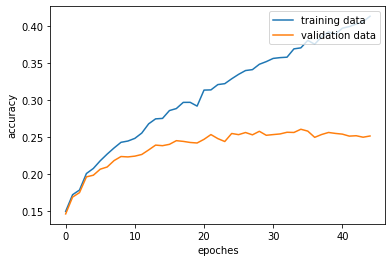

In [18]:
# This shows the error rate of training and testing data after each epoch

x = np.arange(epoches)[0:acc_rate_list.shape[1]]
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.plot(x, acc_rate_list[0,:])
plt.plot(x, acc_rate_list[1,:])
plt.legend(['training data', 'validation data'], loc='upper right')
plt.show()

In [19]:
with torch.no_grad():
    predictionprob = Net.forward(valid_image).cpu().numpy()

In [20]:
prediction = np.argmax(predictionprob, axis = 1)
actual = np.argmax(valid_label.cpu().numpy(), axis = 1)
np.mean(prediction==actual)

0.2513840830449827

In [21]:
maxfive=np.argsort(predictionprob, axis=1)[:,-5:]
actual= np.argmax(valid_label.cpu().numpy(), axis = 1).reshape(-1,1)
np.mean((actual==maxfive).sum(-1))

0.5841695501730104

In [22]:
with torch.no_grad():
    st = time.time()
    predictionprob = Net.forward(test_image).cpu().numpy()
    print("Total time used: ", time.time() - st, "sec")    

Total time used:  0.020797252655029297 sec


In [23]:
prediction = np.argmax(predictionprob, axis = 1)
actual = np.argmax(test_label.cpu().numpy(), axis = 1)
np.mean(prediction==actual)

0.24194301728164408

In [24]:
maxfive=np.argsort(predictionprob, axis=1)[:,-5:]
actual= np.argmax(test_label.cpu().numpy(), axis = 1).reshape(-1,1)
np.mean((actual==maxfive).sum(-1))

0.5843063988790285

In [25]:
from thop import profile
from thop import clever_format

flops, params = profile(Net, inputs=(torch.randn(1, 3, 64, 64).to(device),))
flops, params = clever_format([flops, params], "%.3f")
print(flops, params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
1.973M 65.406K


In [26]:
'''
module = model.conv1
print(list(module.named_parameters()))
print(list(module.named_buffers()))
import torch.nn.utils.prune as prune
prune.random_unstructured(module, name="weight", amount=0.3)
print(list(module.named_parameters()))
print(list(module.named_buffers()))
print(module.weight)
print(module._forward_pre_hooks)
prune.ln_structured(module, name="weight", amount=0.5, n=2, dim=0)
print(module.weight)
for hook in module._forward_pre_hooks.values():
    if hook._tensor_name == "weight":  # select out the correct hook
        break

print(list(hook))
prune.remove(module, 'weight')
print(list(module.named_parameters()))
print(list(module.named_buffers()))
'''

'\nmodule = model.conv1\nprint(list(module.named_parameters()))\nprint(list(module.named_buffers()))\nimport torch.nn.utils.prune as prune\nprune.random_unstructured(module, name="weight", amount=0.3)\nprint(list(module.named_parameters()))\nprint(list(module.named_buffers()))\nprint(module.weight)\nprint(module._forward_pre_hooks)\nprune.ln_structured(module, name="weight", amount=0.5, n=2, dim=0)\nprint(module.weight)\nfor hook in module._forward_pre_hooks.values():\n    if hook._tensor_name == "weight":  # select out the correct hook\n        break\n\nprint(list(hook))\nprune.remove(module, \'weight\')\nprint(list(module.named_parameters()))\nprint(list(module.named_buffers()))\n'

In [27]:
'''
new_model = LeNet5()
for name, module in new_model.named_modules():
    # prune 20% of connections in all 2D-conv layers
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.2)
    # prune 40% of connections in all linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.4)

print(dict(new_model.named_buffers()).keys())  # to verify that all masks exist
'''

"\nnew_model = LeNet5()\nfor name, module in new_model.named_modules():\n    # prune 20% of connections in all 2D-conv layers\n    if isinstance(module, torch.nn.Conv2d):\n        prune.l1_unstructured(module, name='weight', amount=0.2)\n    # prune 40% of connections in all linear layers\n    elif isinstance(module, torch.nn.Linear):\n        prune.l1_unstructured(module, name='weight', amount=0.4)\n\nprint(dict(new_model.named_buffers()).keys())  # to verify that all masks exist\n"

In [29]:
import copy
import torch.nn.utils.prune as prune
Net_copy = copy.deepcopy(Net)

parameters_to_prune = (
    (Net_copy.conv1, 'weight'),
    (Net_copy.conv2, 'weight'),
    (Net_copy.conv3, 'weight'),
    (Net_copy.fc1, 'weight'),
    (Net_copy.fc2, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

In [30]:
#Training loops
st = time.time()
acc_rate_list = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net_copy.parameters(), lr=learning_rate,weight_decay=weight_decay)
counter=0
best_acc=0
for epoch in range(0,epoches):
    print("---------- epoch", epoch+1, "begin ----------")
    
    #loop over each batch
    ste = time.time()
    cost = 0
    mini_batches = random_mini_batches(train_image, train_label, batch_size)
    for i in range(len(mini_batches)):
        batch_image, batch_label = mini_batches[i]
        
        optimizer.zero_grad()
        
        outputs = Net_copy(batch_image)  
        
        loss = criterion(outputs, batch_label)
        
        loss.backward()
        
        optimizer.step()
        
        with torch.no_grad():
            cost += loss.item()
        # print progress
        if i%(int(len(mini_batches)/100))==0:
            sys.stdout.write("\033[F")   #CURSOR_UP_ONE
            sys.stdout.write("\033[K")   #ERASE_LINE
            print ("progress:", int(100*(i+1)/len(mini_batches)), "%, ", "cost =", cost, end='\r')

    sys.stdout.write("\033[F")   #CURSOR_UP_ONE
    sys.stdout.write("\033[K")   #ERASE_LINE
    
    print ("Done, cost of epoch", epoch+1, ":", cost,"                                                                  ")
    
    with torch.no_grad():
        acc_train=torch.mean((torch.max(Net_copy.forward(train_image), 1).indices==torch.max(train_label, 1).indices).to(torch.float32)).item()
        acc_test=torch.mean((torch.max(Net_copy.forward(valid_image), 1).indices==torch.max(valid_label, 1).indices).to(torch.float32)).item()
   
    acc_rate_list.append([acc_train, acc_test])
    print("Accuracy of training set:",  acc_train)
    print("Accuracy of validing set: ",  acc_test)
    print("Time used: ",time.time() - ste, "sec")
    print("---------- epoch", epoch+1, "end ------------")
    if acc_test>best_acc:
        counter =0
        best_acc=acc_test
    else:
        counter+=1
        if counter==5:
            break
acc_rate_list = np.array(acc_rate_list).T
print("Total time used: ", time.time() - st, "sec")

---------- epoch 1 begin ----------
Done, cost of epoch 1 : 384.4720393419266                                                                   89.08747231960297progress: 27 %,  cost = 105.67779457569122progress: 78 %,  cost = 301.82295072078705
Accuracy of training set: 0.41425544023513794
Accuracy of validing set:  0.25017300248146057
Time used:  4.293994903564453 sec
---------- epoch 1 end ------------
---------- epoch 2 begin ----------
Done, cost of epoch 2 : 379.31928765773773                                                                   
Accuracy of training set: 0.42111068964004517
Accuracy of validing set:  0.25415223836898804
Time used:  1.712049961090088 sec
---------- epoch 2 end ------------
---------- epoch 3 begin ----------
Done, cost of epoch 3 : 376.31578612327576                                                                   
Accuracy of training set: 0.42392200231552124
Accuracy of validing set:  0.24757786095142365
Time used:  2.128485679626465 sec
---------

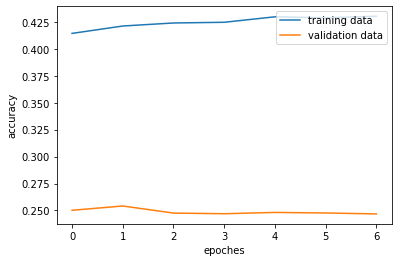

In [31]:
# This shows the error rate of training and testing data after each epoch

x = np.arange(epoches)[0:acc_rate_list.shape[1]]
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.plot(x, acc_rate_list[0,:])
plt.plot(x, acc_rate_list[1,:])
plt.legend(['training data', 'validation data'], loc='upper right')
plt.show()

In [32]:
print(
    "Sparsity in conv1.weight: {:.2f}%".format(
        100. * float(torch.sum(Net_copy.conv1.weight == 0))
        / float(Net_copy.conv1.weight.nelement())
    )
)
print(
    "Sparsity in conv2.weight: {:.2f}%".format(
        100. * float(torch.sum(Net_copy.conv2.weight == 0))
        / float(Net_copy.conv2.weight.nelement())
    )
)
print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(Net_copy.conv2.weight == 0))
        / float(Net_copy.conv2.weight.nelement())
    )
)
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(Net_copy.fc1.weight == 0))
        / float(Net_copy.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(Net_copy.fc2.weight == 0))
        / float(Net_copy.fc2.weight.nelement())
    )
)

print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(Net_copy.conv1.weight == 0)
            + torch.sum(Net_copy.conv2.weight == 0)
            + torch.sum(Net_copy.conv3.weight == 0)
            + torch.sum(Net_copy.fc1.weight == 0)
            + torch.sum(Net_copy.fc2.weight == 0)
        )
        / float(
            Net_copy.conv1.weight.nelement()
            + Net_copy.conv2.weight.nelement()
            + Net_copy.conv3.weight.nelement()
            + Net_copy.fc1.weight.nelement()
            + Net_copy.fc2.weight.nelement()
        )
    )
)

Sparsity in conv1.weight: 28.00%
Sparsity in conv2.weight: 25.71%
Sparsity in conv3.weight: 25.71%
Sparsity in fc1.weight: 15.26%
Sparsity in fc2.weight: 11.12%
Global sparsity: 20.00%


In [33]:
for name, module in Net_copy.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        prune.remove(module, 'weight')

In [34]:
with torch.no_grad():
    st = time.time()
    predictionprob = Net_copy.forward(test_image).cpu().numpy()
    print("Total time used: ", time.time() - st, "sec")    

Total time used:  0.07105326652526855 sec


In [35]:
prediction = np.argmax(predictionprob, axis = 1)
actual = np.argmax(test_label.cpu().numpy(), axis = 1)
np.mean(prediction==actual)

0.23851782656079715

In [36]:
maxfive=np.argsort(predictionprob, axis=1)[:,-5:]
actual= np.argmax(test_label.cpu().numpy(), axis = 1).reshape(-1,1)
np.mean((actual==maxfive).sum(-1))

0.5712283979448856

In [37]:
flops, params = profile(Net_copy, inputs=(torch.randn(1, 3, 64, 64).to(device),))
flops, params = clever_format([flops, params], "%.3f")
print(flops, params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
1.973M 65.406K
